## Alzheimer Detection using CNN

### Essential Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as img
%matplotlib inline

### Data Load

In [2]:
!pip install split-folders

In [3]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Alzheimer/Dataset', output='output',
                   seed=1345, ratio=(.8, 0.1, 0.1))

Copying files: 6400 files [03:22, 31.59 files/s] 


In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './output/train',
    seed=123, label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './output/test',
    seed=123, label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './output/val',
    seed=123, label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### Image Visualization

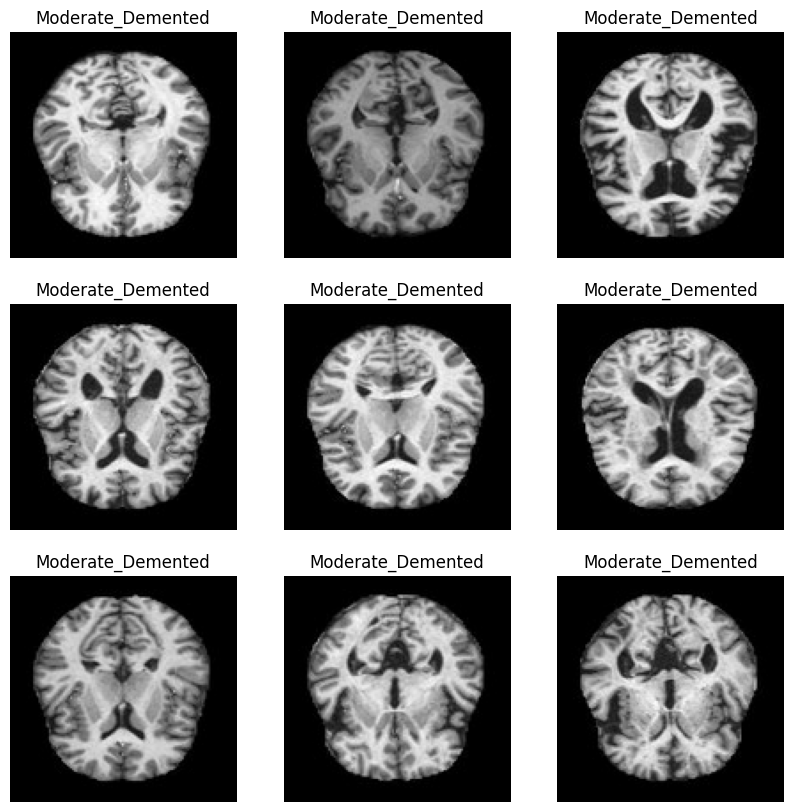

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[int(max(labels[i]))])
    plt.axis('off')

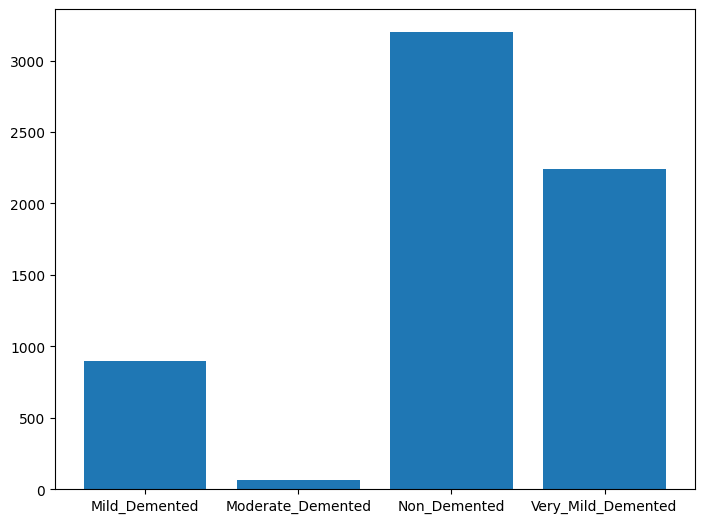

In [7]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
size = [896, 64, 3200, 2240]
ax.bar(class_names, size)
plt.show;

### Model

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(32,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [9]:
model.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=['accuracy',
                                tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),])

In [10]:
filepath = './cnn_best_weights.hdf5'
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='max',
                                              patience=10,
                                              verbose=1)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True,
                           verbose=1)

callbacks_list=[earlystopping,checkpoint]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

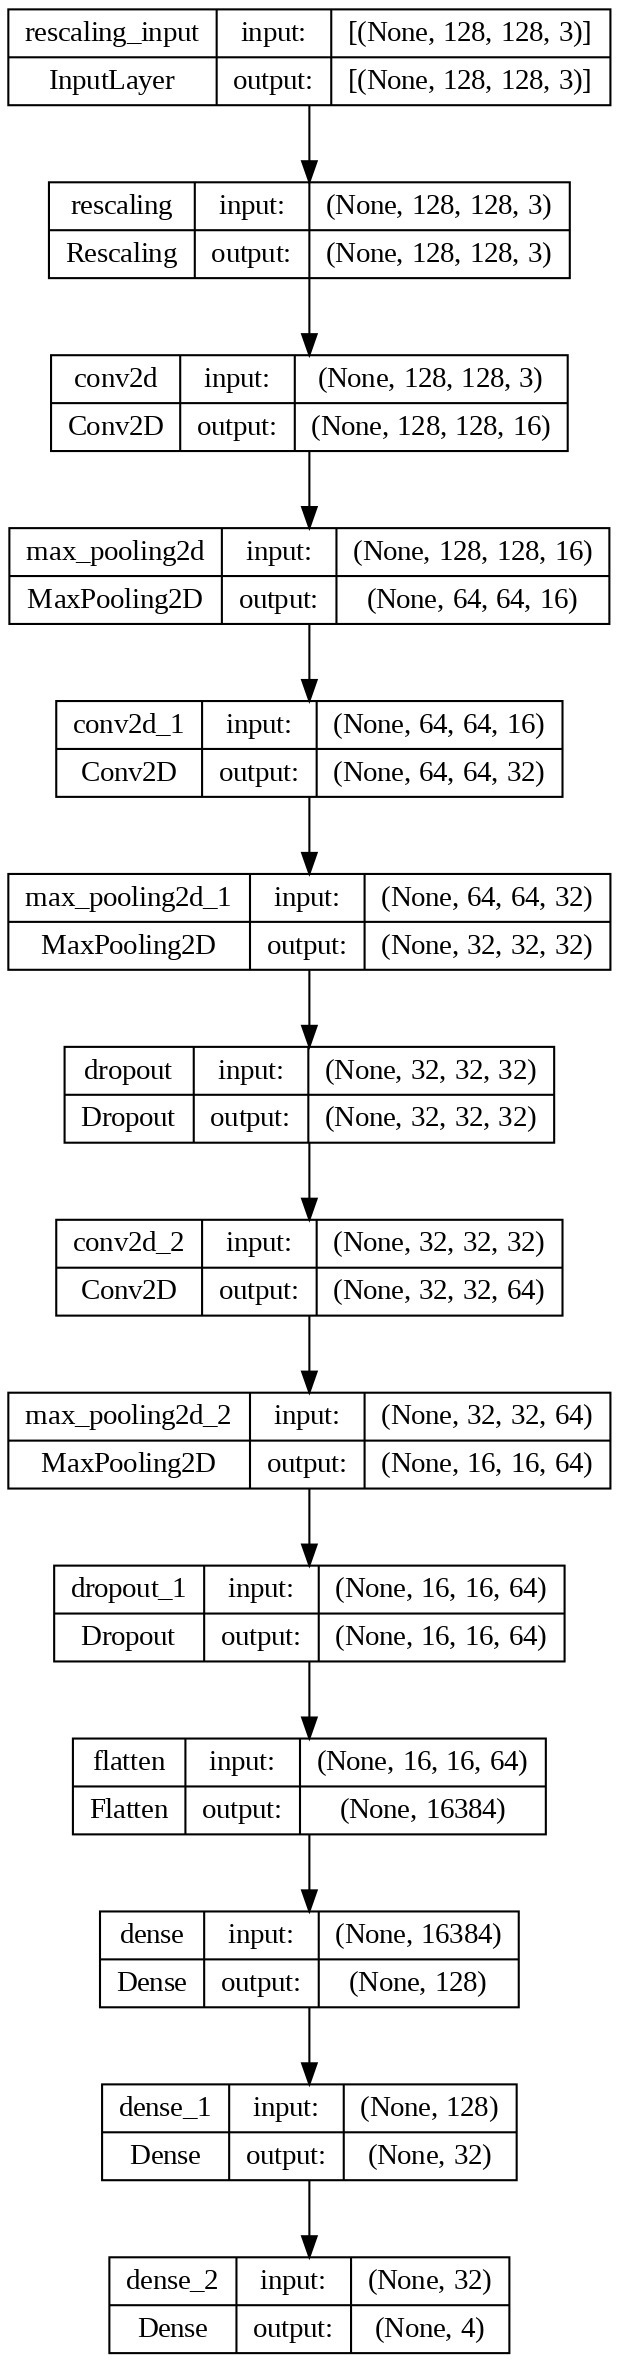

In [12]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=150)

In [13]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1,
                 callbacks= callbacks_list, use_multiprocessing=True)

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.4868 - auc: 0.7709 - precision: 0.5446 - recall: 0.2971
Epoch 1: val_accuracy improved from -inf to 0.53991, saving model to ./cnn_best_weights.hdf5
80/80 [==============================] - 11s 41ms/step - loss: 1.3033 - accuracy: 0.4868 - auc: 0.7709 - precision: 0.5446 - recall: 0.2971 - val_loss: 0.9996 - val_accuracy: 0.5399 - val_auc: 0.8362 - val_precision: 0.8114 - val_recall: 0.2895
Epoch 2/50
 1/80 [..............................] - ETA: 6s - loss: 0.8781 - accuracy: 0.5938 - auc: 0.8709 - precision: 0.7250 - recall: 0.4531

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/80 [============================>.] - ETA: 0s - loss: 0.9364 - accuracy: 0.5568 - auc: 0.8339 - precision: 0.6459 - recall: 0.3831
Epoch 2: val_accuracy improved from 0.53991 to 0.57903, saving model to ./cnn_best_weights.hdf5
80/80 [==============================] - 2s 26ms/step - loss: 0.9350 - accuracy: 0.5577 - auc: 0.8344 - precision: 0.6464 - recall: 0.3835 - val_loss: 0.9031 - val_accuracy: 0.5790 - val_auc: 0.8528 - val_precision: 0.6809 - val_recall: 0.4241
Epoch 3/50
79/80 [============================>.] - ETA: 0s - loss: 0.8873 - accuracy: 0.5787 - auc: 0.8526 - precision: 0.6650 - recall: 0.4377
Epoch 3: val_accuracy improved from 0.57903 to 0.66041, saving model to ./cnn_best_weights.hdf5
80/80 [==============================] - 2s 26ms/step - loss: 0.8848 - accuracy: 0.5806 - auc: 0.8534 - precision: 0.6664 - recall: 0.4401 - val_loss: 0.8051 - val_accuracy: 0.6604 - val_auc: 0.8858 - val_precision: 0.7447 - val_recall: 0.4977
Epoch 4/50
78/80 [=======================

In [14]:
model.save('/content/drive/MyDrive/Alzheimer/Dataset/model.h5')

### Plot the Result

In [15]:
result = model.evaluate(test_ds)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Test Loss = {train_loss}')
print(f'Test Accuracy = {train_accuracy}')
print(f'Test AUC = {train_AUC}')
print(f'Test Precision = {train_pre}')
print(f'Test Recall = {train_rec}')

11/11 [==============================] - 0s 26ms/step - loss: 0.0323 - accuracy: 0.9891 - auc: 0.9998 - precision: 0.9891 - recall: 0.9875
Test Loss = 0.03231028839945793
Test Accuracy = 0.9890965819358826
Test AUC = 0.9998399019241333
Test Precision = 0.9890795350074768
Test Recall = 0.9875389337539673


In [16]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
get_pre = history.history['precision']
get_rec = history.history['recall']
get_auc = history.history['auc']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

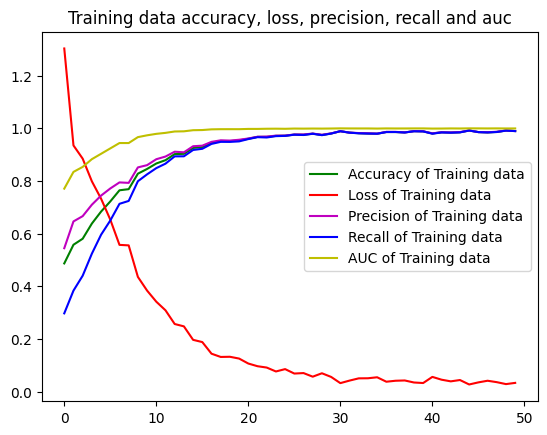

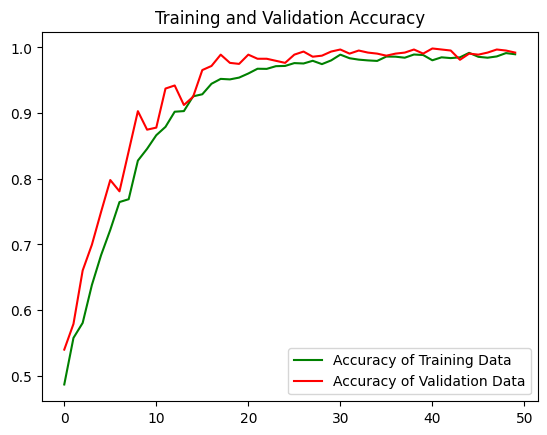

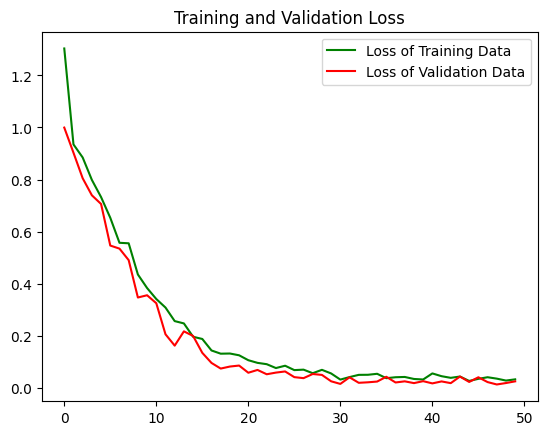

<Figure size 640x480 with 0 Axes>

In [17]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.plot(epochs, get_pre, 'm', label='Precision of Training data')
plt.plot(epochs, get_rec, 'b', label='Recall of Training data')
plt.plot(epochs, get_auc, 'y', label='AUC of Training data')

plt.title('Training data accuracy, loss, precision, recall and auc')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show();

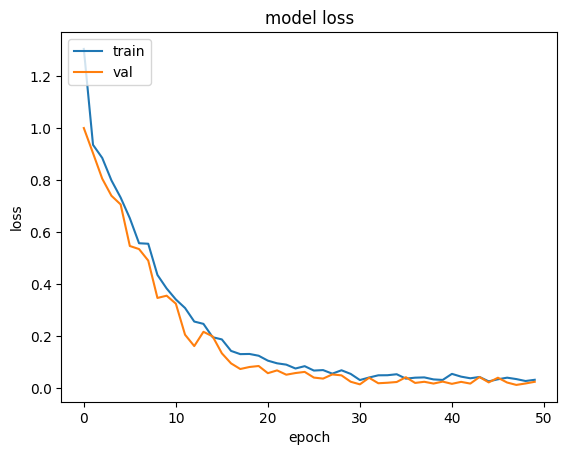

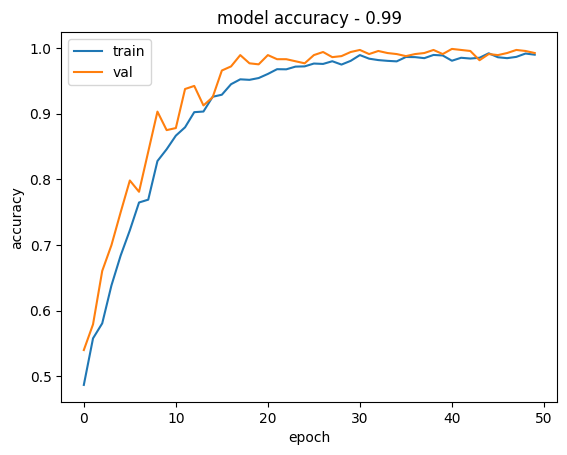

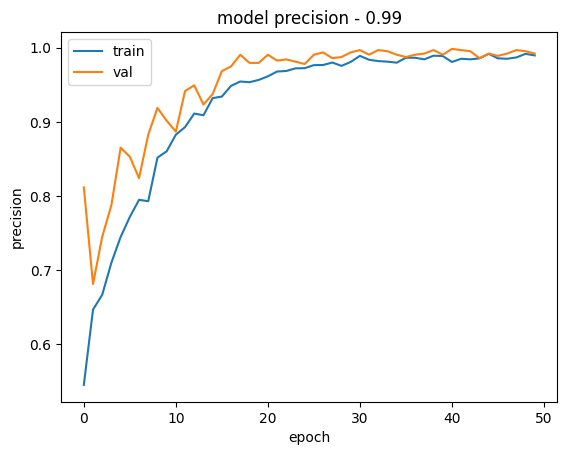

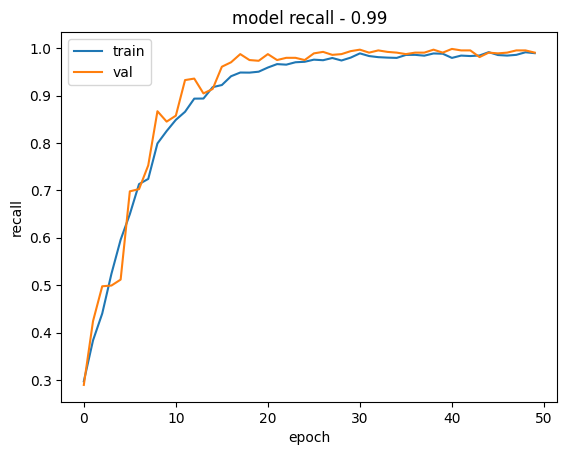

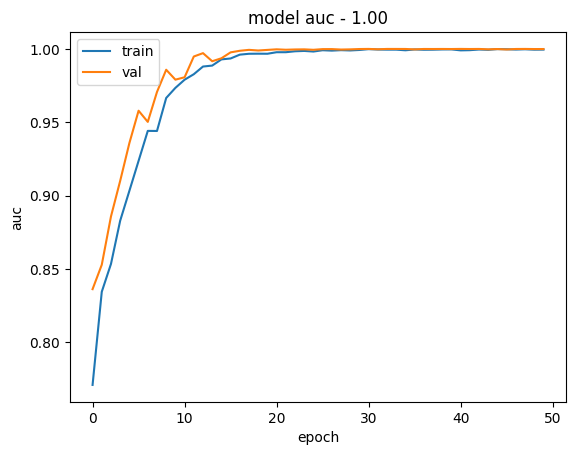

In [18]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(result[1], "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision - ' + str(format(result[3], "0.2f")))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall - ' + str(format(result[4], "0.2f")))
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc - ' + str(format(result[2], "0.2f")))
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 81ms/step


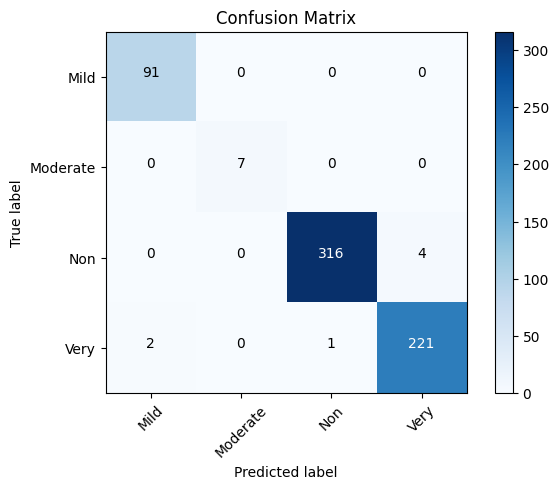

In [19]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from itertools import product
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
confusion_mtx = confusion_matrix(correct_labels, predicted_labels)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
import torch

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of GPUs available: 1
GPU 0: Tesla T4
